<a href="https://colab.research.google.com/github/ninja18/deeplearning-practice/blob/main/attentions/luong-attention/luong-general-attention-de-en-translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Luong Attention
Paper: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025) - Luong et. al 2015

Dataset: [Multi30K English to Deutsche dataset](https://huggingface.co/datasets/bentrevett/multi30k)

Model: Use LSTM as encoder and decoder

### Variations
- Start with Dot product attention and place attention after decoder LSTM and train
- Use learnable projection attention and train
- Do input feeding and train

Skipped local attention since that is mainly for efficiency at this point

**This notebook only covers the general score attention and placing the attention after the decoder**

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
repo_cloned = False
try:
    import google.colab
    is_running_on_colab = True
except ImportError:
    is_running_on_colab = False

In [4]:
# colab specific
import os

if is_running_on_colab:
  %pip install early-stopping-pytorch torchmetrics

  if not repo_cloned:
    repo_cloned = True
    !git clone https://github.com/ninja18/deeplearning-practice.git
    os.chdir('deeplearning-practice/attentions/luong-attention')

  print(os.getcwd())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.4 MB/s eta 0:00:00
Cloning into 'deeplearning-practice'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 378 (delta 150), reused 306 (delta 94), pack-reused 0 (from 0)
Receiving objects: 100% (378/378), 8.56 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/content/deeplearning-practice/attentions/luong-attention


In [5]:
import random
import numpy as np
import torch

SEED = 1557
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from utils.multi30k_data_processing_utils import word_tokenize, build_vocab, preprocess, decode, collate_fn
from utils.multi30k_data_processing_utils import BOS, PAD, EOS

In [7]:
train_dataset = load_dataset("bentrevett/multi30k", split="train")
tokenized_train_dataset = train_dataset.map(lambda x: {"en": word_tokenize(x["en"]), "de": word_tokenize(x["de"])}, batched=False)

en_vocab_to_index, en_index_to_vocab = build_vocab(
    [item["en"] for item in tokenized_train_dataset]
)
de_vocab_to_index, de_index_to_vocab = build_vocab(
    [item["de"] for item in tokenized_train_dataset]
)

preprocessed_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
preprocessed_train_dataset.set_format(type="torch", columns=["source", "target"])

print(preprocessed_train_dataset[0])
print(f"German: {decode(de_index_to_vocab, preprocessed_train_dataset[0]['source'].tolist())}")
print(f"English: {decode(en_index_to_vocab, preprocessed_train_dataset[0]['target'].tolist())}")

loader = DataLoader(
    preprocessed_train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn,
)

batch = next(iter(loader))
print(batch["source"].shape)
print(batch["source_lengths"].shape)
print(batch["target"].shape)
print(batch["target_lengths"].shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

{'source': tensor([   1,   18,   27,  215,   31,   85,   20,   89,    7,   15,  115,    3,
        3149,    4,    2]), 'target': tensor([   1,   16,   24,   15,   25,  776,   17,   57,   80,  204, 1305,    5,
           2])}
German: zwei junge weiße männer sind im freien in der nähe <unk> büsche .
English: two young , white males are outside near many bushes .
torch.Size([3, 15])
torch.Size([3])
torch.Size([3, 16])
torch.Size([3])


In [8]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, device, padding_idx=0):
        super().__init__()
        self.device = device
        self.directions = 2
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout if num_layers > 1 else 0.0, batch_first=True, bidirectional=True)
        self.hidden_projection = nn.Linear(2 * hidden_dim, hidden_dim)
        self.cell_projection = nn.Linear(2 * hidden_dim, hidden_dim)

    def forward(self, source_encodings, source_lengths): # source_encodings: (batch_size, max_length), source_lengths: (batch_size)
        B, T = source_encodings.size()
        h_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)
        c_0 = torch.zeros(self.num_layers * self.directions, B, self.hidden_dim, device=self.device)

        embedded = self.embedding(source_encodings) # (B, T, embedding_dim)
        embedded = self.dropout(embedded)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, source_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_outputs, (last_hidden, last_cell) = self.lstm(packed_embedded, (h_0, c_0)) # hidden: (num_layers * directions, B, hidden_dim)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True) # outputs: (B, T, hidden_dim * directions)

        h_f = last_hidden[0::2] # (num_layers, B, hidden_dim)
        h_b = last_hidden[1::2] # (num_layers, B, hidden_dim)
        h_cat = torch.cat((h_f, h_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension

        c_f = last_cell[0::2] # (num_layers, B, hidden_dim)
        c_b = last_cell[1::2] # (num_layers, B, hidden_dim)
        c_cat = torch.cat((c_f, c_b), dim=2) # (num_layers, B, hidden_dim * 2) concatenate along the hidden dimension


        last_hidden = torch.tanh(self.hidden_projection(h_cat)) # (num_layers, B, hidden_dim)
        last_cell = torch.tanh(self.cell_projection(c_cat)) # (num_layers, B, hidden_dim)

        return outputs, last_hidden, last_cell


In [9]:
from torch.nn import functional as F

class GeneralAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W_a = nn.Linear(hidden_dim, 2 * hidden_dim, bias=False)

    def forward(self, decoder_hidden_states, encoder_outputs, mask): # decoder_hidden_states: (num_layers, B, hidden_dim), encoder_outputs: (B, T, 2 * hidden_dim) bidirectional LSTM
        # use the last hidden state of the multi-layer LSTM decoder as the query
        query = decoder_hidden_states[-1] # (B, hidden_dim)

        # IMPORTANT: There are two ways to implement general attention
        # 1. Project the query to 2 * hidden_dim and then use it to compute the energy
        # 2. Project the encoder outputs to 2 * hidden_dim and then use it to compute the energy
        # Projecting the encoder outputs is more efficient because it is calculated once and reused. But it needs to be computed at the Seq2Seq level and passed in as an argument.
        # I'm going to implement the first one because it is a drop in change and easier to read.
        # Note that both produce the same result because matrix multiplication is associative.
        query_projected = self.W_a(query) # (B, 2 * hidden_dim)

        # change to column vector
        query_projected = query_projected.unsqueeze(2) # (B, 2 * hidden_dim, 1)

        energy = encoder_outputs @ query_projected # (B, T, 1)
        energy = energy.squeeze(2) # (B, T)

        scale = 1.0 / (query_projected.size(-1) ** 0.5)
        energy = energy * scale

        # prevent the attention to the padding tokens and -1e9 is a large negative number.
        # don't use 0 because e^0 = 1
        # don't use -inf because it will cause the softmax to return NaN
        # -1e9 is suitable for float32. For float16, -1e4 is more suitable.
        energy = energy.masked_fill(mask, -1e9)
        attention_weights = F.softmax(energy, dim=1) # (B, T)

        return attention_weights

In [10]:
class LuongAttentionDecoder(nn.Module):
    """
    Decoder for the Seq2Seq model. This works on a batch of single step targets (B, 1).
    It doesn't take the entire target sequence, because the decision to teacher force and what kind of search strategy to use
    is done at the sequence level, not the step level.
    """
    def __init__(self, attention, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, padding_idx=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)
        self.attention = attention
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=False,
        )
        self.attention_projection = nn.Linear(3 * hidden_dim, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, inputs, last_hidden, last_cell, encoder_outputs, mask):
        # Note: (B, 1) is needed because the LSTM expects a 2D input (batch_size, sequence_length)
        inputs = inputs.unsqueeze(1) # (B, 1)

        embedded = self.embedding(inputs)  # (B, 1, embedding_dim)
        embedded = self.dropout(embedded)

        outputs, (hidden, cell) = self.lstm(embedded, (last_hidden, last_cell)) # (B, 1, hidden_dim), (num_layers, B, hidden_dim)

        attention_weights = self.attention(hidden, encoder_outputs, mask) # (B, T)
        attention_weights = attention_weights.unsqueeze(1) # (B, 1, T)
        context_vector = attention_weights @ encoder_outputs # (B, 1, 2 * hidden_dim)

        prediction_input = torch.cat((context_vector, outputs), dim=2) # (B, 1, 2 * hidden_dim + hidden_dim)

        prediction_input = self.dropout(prediction_input)
        prediction_output = torch.tanh(self.attention_projection(prediction_input))
        logits = self.output_projection(prediction_output) # (B, 1, vocab_size)

        return logits, hidden, cell, attention_weights.squeeze(1)

In [11]:
test_encoder = Encoder(len(de_vocab_to_index), 256, 256, 2, 0.0, 'cpu')
test_attention = GeneralAttention(256)
test_decoder = LuongAttentionDecoder(test_attention, len(en_vocab_to_index), 256, 256, 2, 0.0, de_vocab_to_index[BOS])

batch_mask = batch["source"] == de_vocab_to_index[PAD]

encoder_outputs, hidden, cell = test_encoder.forward(batch["source"], batch["source_lengths"])

logits, hidden, cell, attention_weights = test_decoder.forward(batch["target"][:, 0], hidden, cell, encoder_outputs, batch_mask)

print(f"target: {batch['target'][:, 0]}")
print(f"Logits: {logits.shape}")
print(f"Hidden: {hidden.shape}")
print(f"Cell: {cell.shape}")
print(f"Attention weights: {attention_weights.shape}")

print(f"Attention weights: {attention_weights}")

target: tensor([1, 1, 1])
Logits: torch.Size([3, 1, 4560])
Hidden: torch.Size([2, 3, 256])
Cell: torch.Size([2, 3, 256])
Attention weights: torch.Size([3, 15])
Attention weights: tensor([[0.0658, 0.0656, 0.0656, 0.0662, 0.0657, 0.0669, 0.0674, 0.0679, 0.0674,
         0.0670, 0.0670, 0.0677, 0.0672, 0.0667, 0.0659],
        [0.1433, 0.1430, 0.1438, 0.1437, 0.1426, 0.1420, 0.1417, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0713, 0.0712, 0.0711, 0.0720, 0.0719, 0.0713, 0.0712, 0.0711, 0.0715,
         0.0719, 0.0719, 0.0714, 0.0713, 0.0708, 0.0000]],
       grad_fn=<SqueezeBackward1>)


In [12]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, bos_idx, eos_idx, padding_idx, max_target_length, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.padding_idx = padding_idx
        self.max_target_length = max_target_length
        self.device = device

    def forward(self, source, source_lengths, target, teacher_forcing_ratio=0.5):
        B = source.shape[0]
        # Target shape: (B, T) including <bos> and <eos>
        # We process T-1 steps (predicting from <bos> up to second-to-last token)
        target_len = target.shape[1] - 1

        mask = self._create_attention_mask(source)
        encoder_outputs, hidden, cell = self.encoder(source, source_lengths)

        inputs = target[:, 0]
        outputs = torch.zeros(B, target_len, self.decoder.vocab_size, device=self.device)

        for t in range(0, target_len):
            logits, hidden, cell, _ = self.decoder(inputs, hidden, cell, encoder_outputs, mask)
            logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)
            outputs[:, t] = logits

            top1 = logits.argmax(dim=1)

            teacher_force = random.random() < teacher_forcing_ratio
            inputs = target[:, t + 1] if teacher_force else top1

        return outputs

    @torch.no_grad()
    def generate(self, source, source_lengths, topk=0):
        """
        Inference pass for generating translations.
        Returns predicted indices.
        """
        B = source.shape[0]

        mask = self._create_attention_mask(source)
        encoder_outputs, hidden, cell = self.encoder(source, source_lengths)

        inputs = torch.full((B,), self.bos_idx, dtype=torch.long, device=self.device)
        preds_all = [] # using list instead of tensor due to its variable length
        attention_weights_all = []

        for _ in range(self.max_target_length):
            logits, hidden, cell, attention_weights = self.decoder(inputs, hidden, cell, encoder_outputs, mask)
            step_logits = logits.squeeze(1) # (B, 1, vocab_size) -> (B, vocab_size)

            if topk > 0:
                step_preds = self._topk_decode(step_logits, topk)
            else:
                step_preds = step_logits.argmax(dim=1)

            preds_all.append(step_preds.unsqueeze(1))
            attention_weights_all.append(attention_weights)
            inputs = step_preds

            if step_preds.eq(self.eos_idx).all():
                break

        return torch.cat(preds_all, dim=1), torch.stack(attention_weights_all, dim=1)

    def _create_attention_mask(self, source):
        return source == self.padding_idx

    def _topk_decode(self, logits, topk):
        step_logits = logits.squeeze(1) # (B, vocab_size)

        topk_logits, topk_vocab_ids = torch.topk(step_logits, topk, dim=-1) # (B, k)
        topk_probs = torch.softmax(topk_logits, dim=-1) # (B, k)

        sample_pos = torch.multinomial(topk_probs, num_samples=1) # (B, 1)
        preds = topk_vocab_ids.gather(1, sample_pos) # (B, 1)
        return preds.squeeze(1)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
tgt_vocab_size = len(en_vocab_to_index) # 4560
src_vocab_size = len(de_vocab_to_index) # 5422
emb_dim = 512
hidden_dim = 512
dec_hidden_dim = hidden_dim
enc_num_layers = 2
dec_num_layers = 2
enc_dropout = 0.3
dec_dropout = 0.3
padding_idx = de_vocab_to_index[PAD]
bos_idx = de_vocab_to_index[BOS]
eos_idx = de_vocab_to_index[EOS]
max_target_length = 25

batch_size = 128
learning_rate = 0.0005
epochs = 40
max_grad_norm = 1.0
topk = 5
early_stopping_patience = 7
teacher_forcing_decay_constant = epochs / 6

In [15]:
from utils.train_utils import inverse_sigmoid_decay

for e in range(epochs):
    teacher_forcing_ratio = inverse_sigmoid_decay(e, k=teacher_forcing_decay_constant)
    print(f"epoch: {e} Teacher forcing ratio: {teacher_forcing_ratio}")

epoch: 0 Teacher forcing ratio: 0.87
epoch: 1 Teacher forcing ratio: 0.85
epoch: 2 Teacher forcing ratio: 0.83
epoch: 3 Teacher forcing ratio: 0.81
epoch: 4 Teacher forcing ratio: 0.79
epoch: 5 Teacher forcing ratio: 0.76
epoch: 6 Teacher forcing ratio: 0.73
epoch: 7 Teacher forcing ratio: 0.7
epoch: 8 Teacher forcing ratio: 0.67
epoch: 9 Teacher forcing ratio: 0.63
epoch: 10 Teacher forcing ratio: 0.6
epoch: 11 Teacher forcing ratio: 0.56
epoch: 12 Teacher forcing ratio: 0.52
epoch: 13 Teacher forcing ratio: 0.49
epoch: 14 Teacher forcing ratio: 0.45
epoch: 15 Teacher forcing ratio: 0.41
epoch: 16 Teacher forcing ratio: 0.38
epoch: 17 Teacher forcing ratio: 0.34
epoch: 18 Teacher forcing ratio: 0.31
epoch: 19 Teacher forcing ratio: 0.28
epoch: 20 Teacher forcing ratio: 0.25
epoch: 21 Teacher forcing ratio: 0.22
epoch: 22 Teacher forcing ratio: 0.2
epoch: 23 Teacher forcing ratio: 0.17
epoch: 24 Teacher forcing ratio: 0.15
epoch: 25 Teacher forcing ratio: 0.14
epoch: 26 Teacher forcing

In [16]:
encoder = Encoder(src_vocab_size, emb_dim, hidden_dim, enc_num_layers, enc_dropout, device, padding_idx)
general_attention = GeneralAttention(hidden_dim)
decoder = LuongAttentionDecoder(general_attention, tgt_vocab_size, emb_dim, dec_hidden_dim, dec_num_layers, dec_dropout, padding_idx)

model = AttentionSeq2Seq(encoder, decoder, bos_idx, eos_idx, padding_idx, max_target_length, device)
model.to(device)

AttentionSeq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): LuongAttentionDecoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): GeneralAttention(
      (W_a): Linear(in_features=512, out_features=1024, bias=False)
    )
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3)
    (attention_projection): Linear(in_features=1536, out_features=512, bias=True)
    (output_projection): Linear(in_features=512, out_features=4560, bias=True)
  )
)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Seq2Seq model has {count_parameters(model):,} trainable parameters')
print(f"Encoder parameters: {count_parameters(encoder):,}")
print(f"Decoder parameters: {count_parameters(decoder):,}")
print(f"Attention parameters: {count_parameters(general_attention):,}")

The Seq2Seq model has 24,515,536 trainable parameters
Encoder parameters: 14,327,808
Decoder parameters: 10,187,728
Attention parameters: 524,288


In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=de_vocab_to_index[PAD]).to(device)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
from utils.train_utils import train, validate_with_bleu_score, validate_with_teacher_forcing
from utils.multi30k_data_processing_utils import collate_fn

train_dataset = load_dataset("bentrevett/multi30k", split="train")
val_dataset = load_dataset("bentrevett/multi30k", split="validation")

final_train_dataset = train_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_train_dataset.set_format(type="torch", columns=["source", "target"])

final_val_dataset = val_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
final_val_dataset.set_format(type="torch", columns=["source", "target"])

pin_memory = True if device == "cuda" else False

train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)
val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=pin_memory, persistent_workers=True)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

In [22]:
import time
from early_stopping_pytorch import EarlyStopping
from utils.train_utils import epoch_time, inverse_sigmoid_decay

def train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, model_path, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=model_path)
    train_losses = []
    val_losses = []
    val_bleu_scores = []
    teacher_forcing_ratios = []

    for e in range(epochs):
        start_time = time.time()
        teacher_forcing_ratio = inverse_sigmoid_decay(e, k=teacher_forcing_decay_constant)

        train_loss = train(model, train_loader, criterion, optimizer, max_grad_norm, teacher_forcing_ratio, device)
        val_loss = validate_with_teacher_forcing(model, val_loader, criterion, device)
        val_bleu = validate_with_bleu_score(model, val_loader, en_index_to_vocab, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_bleu_scores.append(val_bleu)
        teacher_forcing_ratios.append(teacher_forcing_ratio)

        print(f"Epoch {e+1}: Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val BLEU: {val_bleu:.4f}, Teacher forcing ratio: {teacher_forcing_ratio:.4f}, Epoch time: {epoch_mins}m {epoch_secs}s")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios

In [23]:
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    model_location = '/content/drive/My Drive/ML study/Attentions/luong attention/weights'
    artifacts_location = '/content/drive/My Drive/ML study/Attentions/luong attention/artifacts'
else:
    model_location = 'weights'
    artifacts_location = 'artifacts'

training_prefix = 'luong-general-attention-model'
model_path = f'{model_location}/{training_prefix}.pt'
artifacts_path = f'{artifacts_location}/{training_prefix}-artifacts.json'
loss_graph_path = f'{artifacts_location}/{training_prefix}-loss-graph.png'

Mounted at /content/drive


In [24]:
train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios = train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, model_path, patience=early_stopping_patience)

Epoch 1: Train loss: 4.8447, Val loss: 3.8618, Val BLEU: 0.0504, Teacher forcing ratio: 0.8700, Epoch time: 0m 45s
Validation loss decreased (inf --> 3.861850).  Saving model ...
Epoch 2: Train loss: 3.7388, Val loss: 3.1152, Val BLEU: 0.1316, Teacher forcing ratio: 0.8500, Epoch time: 0m 44s
Validation loss decreased (3.861850 --> 3.115232).  Saving model ...
Epoch 3: Train loss: 3.2223, Val loss: 2.6897, Val BLEU: 0.1982, Teacher forcing ratio: 0.8300, Epoch time: 0m 44s
Validation loss decreased (3.115232 --> 2.689701).  Saving model ...
Epoch 4: Train loss: 2.8846, Val loss: 2.4265, Val BLEU: 0.2426, Teacher forcing ratio: 0.8100, Epoch time: 0m 44s
Validation loss decreased (2.689701 --> 2.426450).  Saving model ...
Epoch 5: Train loss: 2.6506, Val loss: 2.2249, Val BLEU: 0.2676, Teacher forcing ratio: 0.7900, Epoch time: 0m 44s
Validation loss decreased (2.426450 --> 2.224909).  Saving model ...
Epoch 6: Train loss: 2.5075, Val loss: 2.1005, Val BLEU: 0.2901, Teacher forcing rati

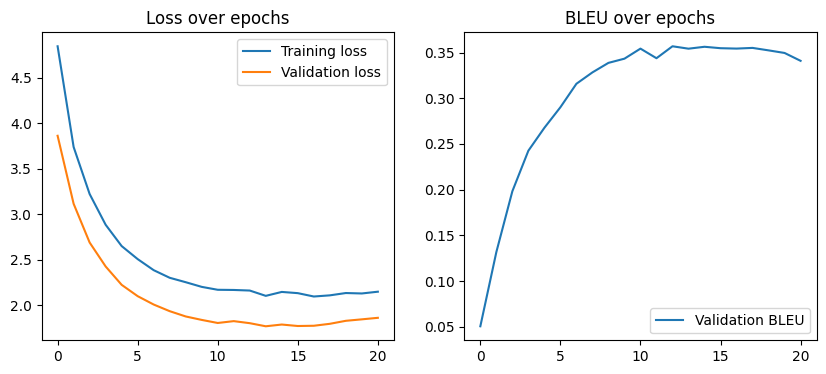

In [25]:
from utils.train_utils import save_artifacts, show_graph

save_artifacts(model, train_losses, val_losses, val_bleu_scores, teacher_forcing_ratios, batch_size, learning_rate, epochs, artifacts_path, model_path, max_grad_norm)
show_graph(train_losses, val_losses, val_bleu_scores, save_path=loss_graph_path, save=True)

In [26]:
from utils.train_utils import load_model
load_model(model, model_path, device)

AttentionSeq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5422, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (hidden_projection): Linear(in_features=1024, out_features=512, bias=True)
    (cell_projection): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): LuongAttentionDecoder(
    (embedding): Embedding(4560, 512, padding_idx=0)
    (dropout): Dropout(p=0.3, inplace=False)
    (attention): GeneralAttention(
      (W_a): Linear(in_features=512, out_features=1024, bias=False)
    )
    (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3)
    (attention_projection): Linear(in_features=1536, out_features=512, bias=True)
    (output_projection): Linear(in_features=512, out_features=4560, bias=True)
  )
)

In [27]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [28]:
from utils.train_utils import translate

test_batch = next(iter(test_loader))
translation_results = translate(model, test_batch, de_index_to_vocab, en_index_to_vocab, topk, device)

Source: <bos> ein ältere frau und ein kleines kind in einem pinkfarbenen shirt spielen mit bunten <unk> .
Pred: an older women and a little child in pink shirt are with colorful <unk> . .
Target: <bos> an older woman and a young child in a pink shirt playing with multicolored blocks .
----------------------------------------------------------------------------------------------------
Source: <bos> vier kinder üben karate während zwei erwachsene zusehen .
Pred: four children practicing karate while two adults watch .
Target: <bos> four children practice karate while two adults watch .
----------------------------------------------------------------------------------------------------
Source: <bos> menschen an der seitenlinie bei einem fußballspiel .
Pred: people at the beach during a soccer game .
Target: <bos> people on the <unk> of a soccer match .
----------------------------------------------------------------------------------------------------
Source: <bos> ein mann in einem orang

Source: <bos> ein ältere frau und ein kleines kind in einem pinkfarbenen shirt spielen mit bunten <unk> .
Pred: an older women and a little child in pink shirt are with colorful <unk> . .
Target: <bos> an older woman and a young child in a pink shirt playing with multicolored blocks .


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


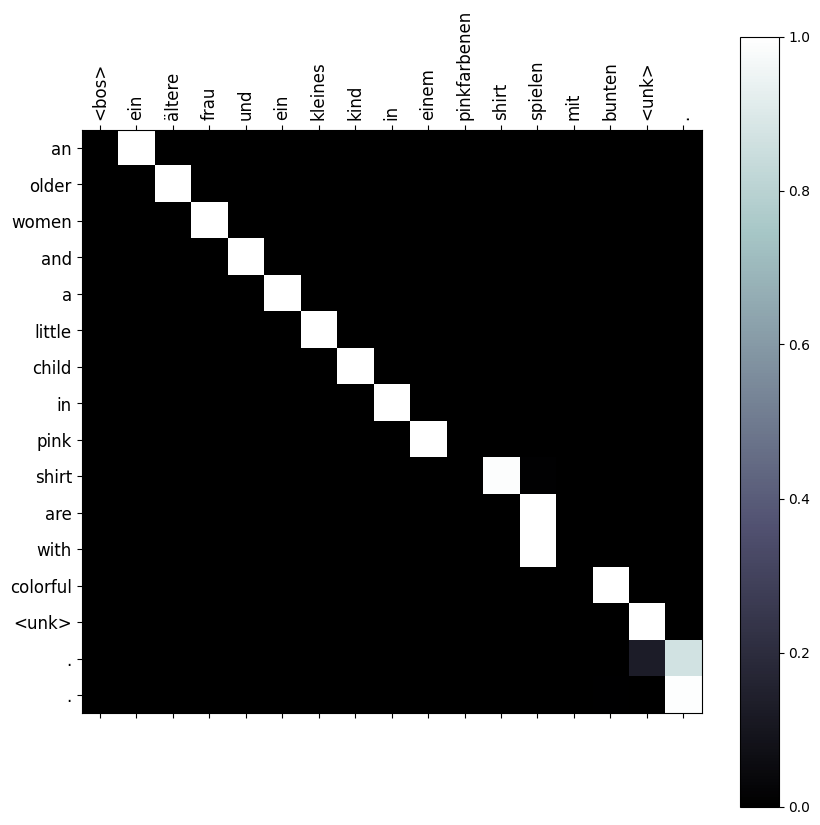

In [35]:
from utils.train_utils import display_attention

one_translation = translation_results[0]
print(f"Source: {" ".join(one_translation['source'])}")
print(f"Pred: {" ".join(one_translation['prediction'])}")
print(f"Target: {" ".join(one_translation['target'])}")

display_attention(one_translation['source'], one_translation['prediction'], one_translation['attention_weights'][:len(one_translation['prediction']), :len(one_translation['source'])])

Source: <bos> 3 jungen stehen in ihren badehosen auf einem pier .
Pred: three boys stand on a pier in their bikinis . .
Target: <bos> 3 boys are standing on a pier in their bathing suits .


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


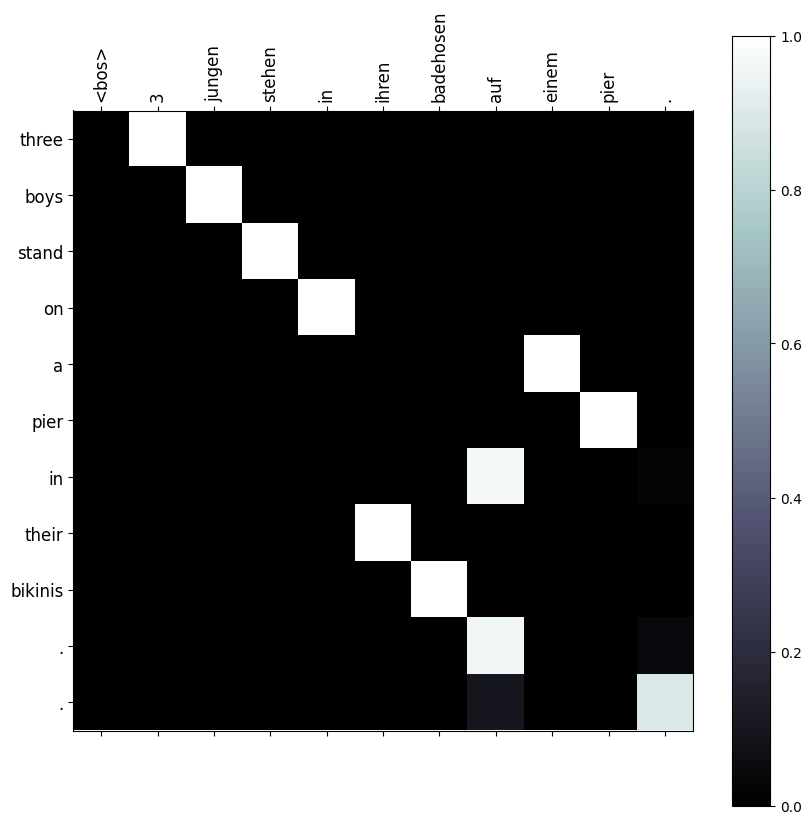

In [31]:
another_translation = translation_results[4]
print(f"Source: {" ".join(another_translation['source'])}")
print(f"Pred: {" ".join(another_translation['prediction']).strip()}")
print(f"Target: {" ".join(another_translation['target']).strip()}")


display_attention(another_translation['source'], another_translation['prediction'], another_translation['attention_weights'][:len(another_translation['prediction']), :len(another_translation['source'])])

Source: <bos> ein mann in einem orangen shirt und ein blonder junge fahren mit anderen personen in einem " <unk> " .
Pred: man in orange shirt and purple blond boy with other people in a . . .
Target: <bos> a man in an orange shirt and a blond boy are riding with other people on a " <unk> " vehicle .


/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:183: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + sentence, rotation=90)
/content/deeplearning-practice/attentions/luong-attention/utils/train_utils.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + translation)


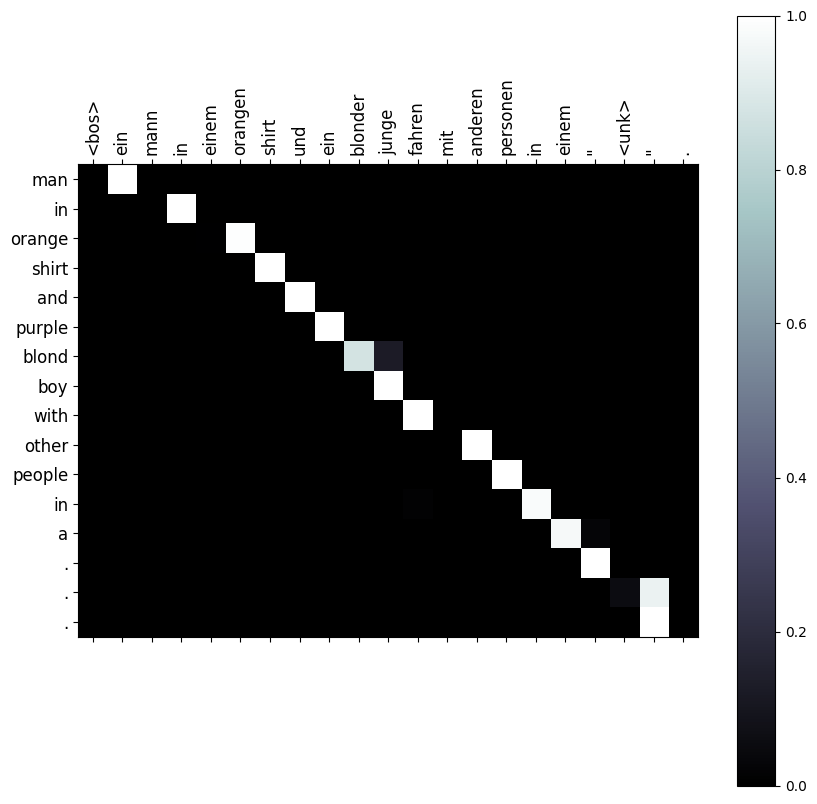

In [32]:
another_translation = translation_results[3]
print(f"Source: {" ".join(another_translation['source'])}")
print(f"Pred: {" ".join(another_translation['prediction']).strip()}")
print(f"Target: {" ".join(another_translation['target']).strip()}")


display_attention(another_translation['source'], another_translation['prediction'], another_translation['attention_weights'][:len(another_translation['prediction']), :len(another_translation['source'])])

In [33]:
test_dataset = load_dataset("bentrevett/multi30k", split="test")
test_dataset = test_dataset.map(
    lambda x: preprocess(x, "de", "en", de_vocab_to_index, en_vocab_to_index),
    batched=True,
    remove_columns=["en", "de"]
)
test_dataset.set_format(type="torch", columns=["source", "target"])

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_bleu_score = validate_with_bleu_score(model, test_loader, en_index_to_vocab, device)

print(f"Test BLEU Score: {test_bleu_score*100:.2f}")

Test BLEU Score: 34.79
